# Pós-graduação em Ciência da Computação - UFABC
## Projeto de Mineração de Dados - Professor Thiago Covões
### Alunos: Fernanda Borges e Thiago Rizuti

# Introdução

O objetivo do projeto é interpretar automaticamente captchas de áudio, que neste caso são áudios com quatro caracteres gravados pelos alunos separadamente e concatenados de forma aleatória em arquivos .wav.

Esta base foi crida considerando-se os seguintes caracteres: a,b,c,d,h,m,n,x,6,7. Ela contém 200 observações para o conjunto de treinamento e 147 observações para o conjunto de validação.

Primeiramente desenvolvemos classificadores capazes de distinguir cada caractere separadamente, sendo que cada caractere do captcha representa uma classe. Em seguida consideramos que para cada arquivo .wav recebido a predição é a combinação das predições individuais para cada caractere.

Para realizar este projeto foram usadas as bibliotecas:
- librosa, que é um pacote para análise de áudios e músicas; 
- pandas, que é uma ferramenta para estruturação e análise de dados;
- numpy, que é muito utilizada para computações científicas;
- matplotlib, que é utilizada principalmente para a plotagem de imagens em 2D;
- sklearn, que possui ferramentas para mineração de dados;

In [1]:
import librosa 
import librosa.display as display
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
%matplotlib inline
import os
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Também implementamos as seguintes funções, que serão explicadas ao longo do relatório.

In [2]:
%load_ext autoreload
%autoreload 2
%aimport codigo
from codigo import read_audio, extract_features, train_model, evaluation_per_character, evaluation_per_captcha

Para fins de reprodutibilidade definimos a random seed como 42

In [3]:
seed=42

# Análise Exploratória

O primeiro desafio foi segmentar cada captcha separando o áudio referente a cada caractere. Para isso utilizamos a função load da biblioteca librosa que retorna a série temporal do áudio e a taxa de amostragem dela. Observamos os espectrogramas de alguns captchas e identificamos que eles condiziam com o processo de gravação dos áudios, pois havia uma separação visual a cada dois segundos (eixo Time) entre as oscilações mais representativas (eixo Hz).

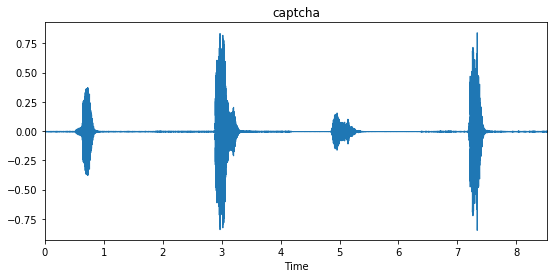

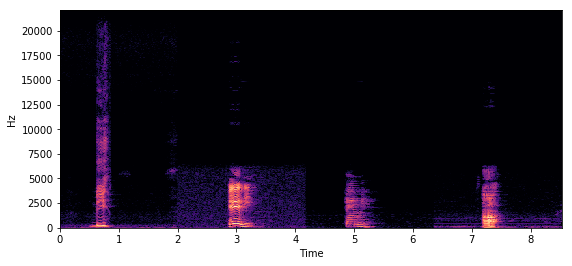

In [8]:
path = 'fase_1_corrigida/base_treinamento_I/'
signal, sampling_rate = librosa.load(os.path.join(path,'bnma.wav'), None)

plt.figure(figsize=(9, 4))
plt.title('captcha')
librosa.display.waveplot(signal, sr=sampling_rate)

X = librosa.stft(signal)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(9,4))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')

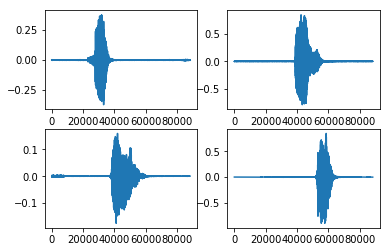

In [9]:
chars = [] 
chars += [signal[sampling_rate*2*i:sampling_rate*2*(i+1)] for i in range(4)]

fig = plt.figure()

plt.subplot(2, 2, 1)
plt.plot(chars[0])

plt.subplot(2, 2, 2)
plt.plot(chars[1])

plt.subplot(2, 2, 3)
plt.plot(chars[2])

plt.subplot(2, 2, 4)
plt.plot(chars[3])

plt.show()

Decidimos então quebrar a série temporal de cada captcha em 4 intervalo de 2 segundos.

Usamos a função read_audio para ler e dividir em caracteres as bases de treinamento e validação.

In [10]:
train_audios = read_audio('fase_1_corrigida/base_treinamento_I/')
valid_audios = read_audio('fase_1_corrigida/base_validacao_I')

print('base de treinamento: ', len(train_audios), ' captchas')
print('base de validação: ', len(valid_audios), ' captchas')

base de treinamento:  800  captchas
base de validação:  588  captchas


Para a extração das variáveis de cada caractere utilizamos o Mel Frequency Cepstral Coefficents (MFCCs) que é a ferramenta amplamente utilizada para reconhecimento automático de fala.

Os sons gerados por humanos são filtrados pelo formato do trato vocal, incluindo a língua, os dentes, etc. Este formato determina como o som é emitido. Considerando que seja possível determinar acuradamente este formato, podemos então assumir que temos uma representação acurada do fonema que está sendo reproduzido. 

O formato do trato vocal se manifesta em um envelope do espectro de força em um espaço curto de tempo, e o trabalho dos MFCCs é representar este envelope de maneira precisa.

O processamento do Mel-Frequency Cepstral Coefficients realiza primeiramente o janelamento e aplica a Transformada Discreta de Fourier (DFT). A amplitude da Transformada de Fourier é filtrada por janelas triangulares na escala Mel e então aplica-se o logaritmo. A Transformada Discreta de Cosseno é aplicada e os Coeficientes Mel-Cepstrais são as amplitudes resultantes.

Na função extract_features utilizamos a funcionalidade librosa.feature.mfcc para obter a sequência de MFCCs de cada caractere. Este processo retorna uma matriz com 20 linhas e 173 colunas por caractere. Calculamos então a média da moda, o valor mínimo, o valor máximo, a média, o desvio padrão, a mediana, a amplitude interquartil, a curtose e a assimetria por linha.

In [11]:
train_data = extract_features(train_audios,n_mfcc=20)
valid_data = extract_features(valid_audios,n_mfcc=20)

print('base de treinamento: ', train_data.shape)
print('base de validação: ', valid_data.shape)

base de treinamento:  (800, 182)
base de validação:  (588, 182)


In [12]:
train_data.head()

,char_label,captcha_label,mfcc_0_mode,mfcc_0_min,mfcc_0_max,mfcc_0_mean,mfcc_0_std,mfcc_0_median,mfcc_0_iqr,mfcc_0_kutosis,...,mfcc_18_skewness,mfcc_19_mode,mfcc_19_min,mfcc_19_max,mfcc_19_mean,mfcc_19_std,mfcc_19_median,mfcc_19_iqr,mfcc_19_kutosis,mfcc_19_skewness
0,6,66bx,-279.487543,-559.975087,-217.100086,-439.666959,105.556413,-512.589937,195.543426,-1.394238,...,-0.533771,-4.576643,-10.153286,13.826280,2.178177,4.770973,2.495411,6.454944,-0.234770,-0.181391
1,6,66bx,-320.472502,-641.945005,-315.053993,-550.774213,95.463676,-595.209760,164.138651,-0.572486,...,-0.767729,-5.441521,-11.883042,15.200052,2.806590,5.505255,3.525824,6.682836,-0.127157,-0.254066
2,b,66bx,-271.560884,-544.121768,-190.378934,-460.414313,90.769454,-492.580679,49.340930,2.845994,...,0.097288,-8.985710,-18.971420,9.584314,-5.304728,6.049147,-4.913533,8.102776,-0.192530,-0.083290
3,x,66bx,-276.442821,-553.885642,-230.223358,-396.314779,85.108663,-407.785461,74.717911,-0.491782,...,-0.025678,-7.474772,-15.949544,12.878341,0.768482,5.653034,1.736725,7.193342,0.063185,-0.491037
4,6,66c7,-213.313958,-427.627917,-314.112681,-403.099175,25.990087,-414.487857,22.830799,2.831519,...,-0.097430,-1.755146,-4.510293,13.909018,5.308853,4.011962,5.423098,5.908655,-0.605295,-0.158264


In [13]:
valid_data.head()

,char_label,captcha_label,mfcc_0_mode,mfcc_0_min,mfcc_0_max,mfcc_0_mean,mfcc_0_std,mfcc_0_median,mfcc_0_iqr,mfcc_0_kutosis,...,mfcc_18_skewness,mfcc_19_mode,mfcc_19_min,mfcc_19_max,mfcc_19_mean,mfcc_19_std,mfcc_19_median,mfcc_19_iqr,mfcc_19_kutosis,mfcc_19_skewness
0,6,6a7h,-284.041272,-569.082544,-246.044152,-447.790719,102.922863,-510.873237,192.624199,-1.471761,...,-0.363009,-4.469375,-9.938750,12.569022,0.567821,4.628870,1.335582,6.522515,-0.576846,-0.121141
1,a,6a7h,-279.649331,-560.298661,-213.095023,-406.506435,64.636606,-415.338957,16.241729,1.950714,...,0.842956,-7.665045,-16.330091,11.822620,0.465108,4.475593,0.654584,5.709730,1.083686,-0.637402
2,7,6a7h,-327.675648,-656.351296,-294.850188,-523.927264,129.384149,-604.178438,222.153782,-1.437636,...,-0.349725,-6.048140,-13.096280,17.385526,3.152003,5.816633,3.788628,6.265887,0.624435,-0.567305
3,h,6a7h,-315.132664,-631.265329,-247.910469,-495.083417,102.847084,-537.889118,74.484540,0.200829,...,0.861674,-7.024527,-15.049054,17.555894,2.587710,5.007658,2.615753,5.964188,0.892873,-0.035594
4,6,6ama,-274.830667,-550.661335,-174.870741,-425.286200,120.048059,-493.257278,214.184467,-1.143365,...,-0.317575,-3.738463,-8.476926,12.290704,1.312996,3.745316,1.342250,4.900278,-0.051027,-0.113018


#  Metodologia

Depois de extrair as variáveis adotamos a mesma abordagem de quando se lida com um problema de classificação tradicional.

Nós utilizamos o GridSearchCV do sklearn para comparar diferentes modelos e configurações de hiperparâmetros. 

Definimos a validação cruzada, de modo que o conjunto de dados de treino disponibilizado pelo professor fosse utilizado para treino e o conjunto de dados de validação fosse utilizado para calcular a métrica de avaliação (acurácia). 
Executamos o grid search uma vez para cada um dos modelos com cada uma das diferentes combinações de hiperparâmetros , calculando assim a acurácia na base de validação. 
Desta maneira foi possível escolher o melhor modelo com a melhor combinação de hiperparâmetros selecionando o maior best_score.

Os modelos testados foram: 
- Gaussian Naive Bayes (hiperparâmetros: nenhum)
- k-nearest neighbors (hiperparâmetros: número de vizinhos, votação uniforme ou ponderada pela distância, distâncias de manhattan e euclidiana)
- Regressão Logística (peso da regularização, regularizão l1 e l2)
- Árvore de Decisão (profundidade máxima)
- Random Forest (profundidade máxima e número de árvores.

Antes de treinar os modelos, usamos também o StandardScaler do sklearn para normalizar os dados com z-score.

In [14]:
transformer = StandardScaler()

estimators = [GaussianNB(),KNeighborsClassifier(),LogisticRegression(),
              DecisionTreeClassifier(),RandomForestClassifier()]
    
param_grids = [{},
           {'n_neighbors':[2,5,7,10,12], 'weights':['uniform','distance'],'p':[1,2]},
           {'C':np.logspace(-4,4,9),'penalty':['l1','l2'],'random_state':[seed]},
           {'max_depth':np.linspace(2,15,20),'random_state':[seed]},
           {'max_depth':np.linspace(2,15,20),'n_estimators':[50],'random_state':[seed]}]

metric = 'accuracy'

A metodologia descrita foi toda implementada na função train_model. 
A função recebe os dados de treinamento e validação, a lista de modelos, lista de hiperparâmetros, o normalizador e a métrica a ser utilizada. Retornando o normalizador ajustado, o melhor modelo treinado e uma tabela de resultados do gridsearch.

In [15]:
transformer, best_model, results = train_model(train_data,valid_data,transformer,estimators,
                                               param_grids,metric)

#  Resultados

A tabela abaixo mostra os resultados do gridsearch. Observamos que a RegressãoLogística foi a que obteve melhor resultado no conjunto de validação, sendo este escolhido como o melhor modelo.

In [16]:
pd.DataFrame(results).sort_values(by='validation metric',ascending=False).reset_index(drop=True)

,estimator,training metric,validation metric
0,LogisticRegression,0.9600,0.789116
1,KNeighborsClassifier,1.0000,0.770408
2,RandomForestClassifier,1.0000,0.751701
3,GaussianNB,0.6700,0.544218
4,DecisionTreeClassifier,0.9425,0.506803


O melhor valor de regularização escolhido foi 1, isto é, um modelo sem regularização.

In [16]:
print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Implementamos a função evaluate_by_character para avaliar com mais detalhes o melhor modelo escolhido. A função calcula a matriz de confusão, precision, recall e f1 para cada classe. 

A função também retorna uma matriz de confusão que nos permitiu observar que o modelo confunde bastante a classes m com a classe n, a classe d com a classe b, e assim por diante.

In [19]:
metrics, conf = evaluation_per_character(transformer,best_model,valid_data)

In [20]:
conf

,6,a,7,h,m,c,d,x,n,b
6,50,0,0,0,1,10,0,2,0,2
a,0,58,2,1,0,0,0,0,0,1
7,2,0,55,0,1,1,0,2,0,0
h,0,0,1,67,0,2,0,0,0,0
m,0,0,1,1,37,0,3,0,15,5
c,3,0,10,0,2,50,0,1,0,3
d,1,0,0,1,1,1,21,0,0,23
x,4,0,0,0,0,0,0,42,0,0
n,0,0,0,0,11,0,1,0,34,1
b,0,0,0,0,1,0,5,0,2,50


In [21]:
print(metrics)

             precision    recall  f1-score   support

          6       0.83      0.77      0.80        65
          7       0.80      0.90      0.85        61
          a       1.00      0.94      0.97        62
          b       0.59      0.86      0.70        58
          c       0.78      0.72      0.75        69
          d       0.70      0.44      0.54        48
          h       0.96      0.96      0.96        70
          m       0.69      0.60      0.64        62
          n       0.67      0.72      0.69        47
          x       0.89      0.91      0.90        46

avg / total       0.80      0.79      0.79       588



Por fim criamos a função evaluation_per_captcha que retorna a quantidade de captchas nos quais nosso melhor modelo foi capaz de acertar os 4 caracteres, dividida pela quantidade total de captchas de validação. Sendo que nosso resultado final foi acertar aproximadamente 40% dos captchas de validação.

In [24]:
evaluation_per_captcha(transformer,best_model,valid_data)

0.40816326530612246

# Comentários Finais

Acertamos os 4 caracteres em 40% dos captchas de validação e identificamos que poderíamos melhorar consideravelmente esta taxa de acerto se o modelo não confundisse tanto o caractere d com o caractere b, por exemplo.

Para melhorar o desempenho do modelo poderíamos:
- Extrair mais variáveis através do mfcc;
- Explorar outras bibliotecas de extração de variáveis, por exemplo a python_speech_features;
- Fazer kfold somente com o conjunto de dados de treinamento para minimizar o overfitting;
- Testar ensembles e classificadores específicos para os caracteres mais similares;

# Referências

http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

http://abricom.org.br/wp-content/uploads/2016/03/bricsccicbic2013_submission_55.pdf

https://librosa.github.io/librosa/index.html

http://scikit-learn.org/stable/modules/classes.html
